# Layout:

1.	Import Packages/Libraries
2.	Read Dataset From Scrape
3.	Clean Data and add Dummy Variables
    + Remove Duplicate Values
    + Set Column Value Types from Object to Regression-Friendly Values
    + Turn Categorical Data into 0//1 Variables
    + Drop Movies/Anime
4.	Split Data into Train and Test Sets
    + Split Dependent and Independent Variables
    + Make Train/Test Datasets and Turn Training into a DataFrame
    + Remove Outliers from Training Set
    + Further Split Train Set into 10 Folds
5.	Exploratory Data Analysis (EDA) on Train Data
    + Pairplots of All Variables
    + Correlations
6.	Base OLS Model on Original Train Data
    + OLS Fit and Summary
    + K-Fold Validation
    + Plot Prediction vs Actual
7.	Diagnostic Plots on Base Model
    + Residuals vs Fitted
    + Normal Q-Q
    + Scale-Location
    + Residuals vs Leverage
8.	Rescale Data As Needed
    + Log and Plot Dependent
    + Attempt Boxcox Transformations and Plot- Ignore Results
9.	EDA on Scaled Data
10.	Regression on Logged Values
    + Drop Multicollinear Elements
    + Run OLS Fit and Summary
    + Run K-Fold CV
    + **Plot Prediction vs Actual**
11.	Diagnostic Plots on Updated Train Data
    + Residuals vs Fitted
    + Normal Q-Q
    + Scale-Location
    + Residuals vs Leverage
12.	**Polynomial Features**
13.	Compare Linear and More Complicated Models’ R2 Scores
    + Make Function to Compare with Previously Made K-Folds
    + Run Comparison on Train Data
    + Run on Modified Data
14.	Check Inputs of Best Model on Entire Train Data to Maximize R2 and Minimize Overfitting
15.	Run “Best” Model on Entire Testing Data (Holdout Set)
16.	Plot Final Results

# Mass Importation

In [ ]:
import pandas as pd
import numpy as np
import dateutil.parser
from datetime import date
import re

from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy import stats
from sklearn import linear_model,ensemble, tree, model_selection, datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import diagnostic_plots

import pickle
import time

# Read Dataset from Scrape

In [ ]:
df=pd.read_csv('steam3.csv')
del(df['Unnamed: 0'])
df.set_index('title', inplace=True)
df.head()

# Clean Data and Add Dummy Variables

## Remove Duplicates

In [ ]:
no_dup_df = df[~df.index.duplicated(keep='first')]

## Set Column Value Types

In [ ]:
no_dup_df['system'] = no_dup_df.system.astype(int)
no_dup_df['reviews'] = no_dup_df.reviews.astype(int)
no_dup_df['release_date'] = no_dup_df.release_date.astype(int)
no_dup_df['discount'] = no_dup_df.discount.astype(int)
no_dup_df['price'] = no_dup_df.price.astype(float)
no_dup_df['systems'] = no_dup_df.systems.astype(list)

## Windows, Mac, Linux -> Dummy Variables

In [ ]:
windows=[1 if 'win' in item else 0 for item in no_dup_df.systems]
mac=[1 if 'mac' in item else 0 for item in no_dup_df.systems]
linux=[1 if 'linux' in item else 0 for item in no_dup_df.systems]

In [ ]:
no_dup_df['windows']=windows
no_dup_df['mac']=mac
no_dup_df['linux']=linux

In [ ]:
no_dup_df['windows'] = no_dup_df.windows.astype(int)
no_dup_df['mac'] = no_dup_df.mac.astype(int)
no_dup_df['linux'] = no_dup_df.linux.astype(int)
#no_dup_df.info()

## Drop Streaming Videos

In [ ]:
movies=[]
for i in range(len(no_dup_df['systems'])):
    element=(no_dup_df['systems'][i])
    if 'win' not in element and 'mac' not in element and 'linux' not in element:
        movies.append(1)
    else:
        movies.append(0)
no_dup_df['movies']=movies
no_dup_df = no_dup_df[no_dup_df.movies != 1]
del(no_dup_df['movies'])

# Split Data into Train/Test

## Split Dependent and Independent Variables From Original Dataset

In [ ]:
y = no_dup_df['reviews']
X = no_dup_df.drop(['reviews','link','systems'], axis = 1)

## Make Train/Test Sets and Put in DataFrame

In [ ]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.3)
tdf=X_t.join(y_t)

## Remove Outliers from Training Set

In [ ]:
traindf=tdf[tdf.reviews < 100000]
y_train = traindf['reviews']
X_train = traindf.drop(['reviews'], axis = 1)

## 10-fold Cross Validation Split

In [ ]:
kf=KFold(n=len(X_train), n_folds=10, shuffle=True, random_state=20)

# Exploratory Data Analysis on Train Data

## Pairplot

In [ ]:
sns.pairplot(traindf, size = 1.2, aspect=1.5)

## Correlation Matrix

In [ ]:
traindf.corr()
#sns.heatmap(no_dup_df.corr(), cmap="seismic")

# Base Model

## OLS Fit and Summary

In [ ]:
model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()
fit.summary()

## K-Fold Validation; Return Average Score Across Folds

In [ ]:
all_scores_lr_train = []
all_scores_lr_test = []

for train, test in kf:
    Xt_train = X.iloc[train]
    yt_train=y.iloc[train]
    X_val = X.iloc[test]
    y_val = y.iloc[test]
    
    lr=LinearRegression()
    lr.fit(Xt_train, yt_train)
    all_scores_lr_train.append(lr.score(Xt_train,yt_train))
    all_scores_lr_test.append(lr.score(X_val,y_val))
    
    lr.fit(X_val,y_val)

np.mean(all_scores_lr_train), np.mean(all_scores_lr_test)

## Plot Predicted vs Actual

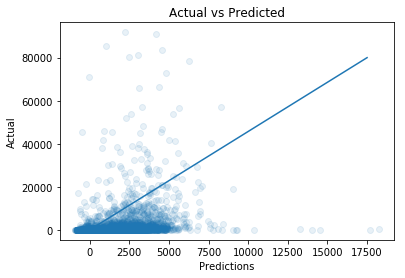

In [144]:
predict = fit.predict(X_train)
plt.scatter(predict,y_train,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,17500,1000),np.linspace(0,80000,1000));
plt.title('Actual vs Predicted');

# Diagnostic Plots on Base Model

In [ ]:
y_traindf=pd.DataFrame(y_train)
X_traindf=pd.DataFrame(X_train)
diagnostic_plots.diagnostic_plots(X_traindf, y_traindf, fit)

# Rescale/Normalize Data

## Log Dependent Data

In [ ]:
traindf['log_reviews'] = np.log(traindf.reviews + 1)
plt.hist(traindf['log_reviews'])

## Boxcox- makes no difference, stick to log

In [ ]:
yt, _ = stats.boxcox(traindf['reviews']+1)

In [ ]:
plt.hist(yt)

# EDA on Scaled Data, Log Reviews as Dependent

In [ ]:
sns.pairplot(traindf[traindf.release_date > 30])

In [ ]:
traindf.corr()

# Regression on Log Values

## Drop Highly Multicollinear Elements
+ Those with no reviews
+ That don't run on windows

In [ ]:
mask = (traindf.reviews > 0) | (traindf.windows == 1)

## OLS Model

In [ ]:
traindf2 = traindf[mask]
y2_train = traindf2['log_reviews']
X2_train = traindf2.drop(['log_reviews','reviews', 'system', 'windows'], axis = 1)

model2 = sm.OLS(y2_train, sm.add_constant(X2_train))
fit2 = model2.fit()
fit2.summary()

## K-Fold CV

In [ ]:
all_scores_lr_train2 = []
all_scores_lr_test2 = []

for train, test in kf:
    Xt_train2 = X2.iloc[train]
    yt_train2 = y2.iloc[train]
    X_val2 = X2.iloc[test]
    y_val2 = y2.iloc[test]
    
    lr=LinearRegression()
    lr.fit(Xt_train2, yt_train2)
    all_scores_lr_train2.append(lr.score(Xt_train2, yt_train2))
    all_scores_lr_test2.append(lr.score(X_val2,y_val2))
    
    lr.fit(X_val2,y_val2)

np.mean(all_scores_lr_train2), np.mean(all_scores_lr_test2)

## Plot Predicted vs Actual

Text(0.5,1,'Actual vs Predicted')

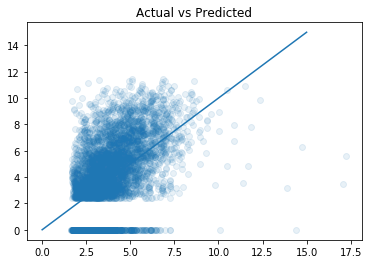

In [145]:
predict2 = fit2.predict(sm.add_constant(X2_train))
plt.scatter(predict2,y2_train,alpha=.1)
plt.plot(np.linspace(0,15,100),np.linspace(0,15,100))
plt.title('Actual vs Predicted')

# Diagnostic Plot on Logged/Dropped Values

In [ ]:
y_traindf2=pd.DataFrame(y2_train)
X_traindf2=pd.DataFrame(X2_train)
diagnostic_plots.diagnostic_plots(X_traindf2, y_traindf2, fit2)

# Polynomial Features

In [ ]:
# x_plot = np.linspace(0, 1, 100)
# fig, ax_rows = plt.subplots(5, 2, figsize=(15, 20))

# def plot_approximation(est, ax, label=None):
#     """Plot the approximation of ``est`` on axis ``ax``. """
#     ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
#     ax.scatter(X, y, s=100)
#     ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
#     ax.set_ylim((-2, 2))
#     ax.set_xlim((0, 1))
#     ax.set_ylabel('y')
#     ax.set_xlabel('x')
#     ax.legend(loc='upper right',frameon=True)

# for degree in range(10):
#     est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
#     est.fit(X2, y2)
#     ax_row_left, ax_row_right = ax_rows[degree//2]
#     if degree%2 == 0:
#         ax = ax_row_left
#     else:
#         ax = ax_row_right
#     plot_approximation(est, ax, label='degree=%d' % degree)
X2

# Compare Different Models

## Function to Compare Each Model's Mean R2 Within Folds

In [ ]:
def get_scores(X, y, folds = 10, alpha = 0.5): 

    models = {}
    parameters = {}
    
    models['linear_model'] = linear_model.LinearRegression()
    models['ridge_model'] = linear_model.Ridge()
    models['lasso_model'] = linear_model.Lasso(alpha=alpha)
    models['robust_regression'] = linear_model.SGDRegressor(loss='huber',max_iter=2000)
    models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',max_iter=2000)
    models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
    models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
    models['randomForest'] = ensemble.RandomForestRegressor()
    models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
    models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()
    
    
    overall_scores_train=[]
    overall_scores_test=[]
    for name,model in models.items():
        scores_train=[]
        scores_test=[]
        for train, test in kf:
            Xt_train = X.iloc[train]
            yt_train=y.iloc[train]
            X_val = X.iloc[test]
            y_val = y.iloc[test]

            model.fit(Xt_train, yt_train)
            
            scores_train.append(model.score(Xt_train,yt_train))
            scores_test.append(model.score(X_val,y_val))
            lr.fit(X_val,y_val)

        overall_scores_train.append(np.mean(scores_train))
        overall_scores_test.append(np.mean(scores_test))
    
    scores_df = pd.DataFrame({'Model': list(models.keys()),
                             'Train Scores': overall_scores_train, 'Test Scores': overall_scores_test})

    return scores_df

### Compare with Unlogged Data

In [ ]:
get_scores(X_train,y_train, folds = 10, alpha = 0.5)

### Compare with Logged/Modified Data

In [ ]:
get_scores(X2_train, y2_train, folds = 10, alpha = 0.5)

## Result: Gradient Boosted Trees is "Best" Model

# Play with Model to Determine "Best" Input Values and Run on Entire Training Data
Best Input in Terms of Mean Score on Test Data Folds

In [ ]:
gb = ensemble.GradientBoostingRegressor(alpha=0.9, n_estimators=200, min_samples_split=2, max_depth=3)
cross_val_score(gb, X2_train, y2_train, cv = 10, n_jobs=1, scoring="r2").mean()

# Run Gradient Boosted Trees on Holdout Set- Get Scores

In [ ]:
testdf=X_test.join(y_test)
testdf['log_reviews'] = np.log(testdf.reviews + 1)

y2_test = testdf['log_reviews']
X2_test = testdf.drop(['log_reviews','reviews', 'system', 'windows'], axis = 1)

cross_val_score(gb, X2_test, y2_test, n_jobs=1, scoring="r2").mean()

# Plot Final Results

In [ ]:
gb.fit(X2_train,y2_train)
predictions = gb.predict(X2_test)
plt.scatter(predictions,y2_test,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,15,1000),np.linspace(0,15,1000));
plt.title('Actual vs Predicted');